# segy reader

### imports

In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
from PIL import Image
from obspy.io.segy.segy import _read_segy
import matplotlib.pyplot as plt
%matplotlib inline

### reader class

In [12]:

class MultiInlineReader(object):

    def __init__(self, path, batch_size, file_extension=".sgy", max_size=-1):
        self._idx = None
        self.path = path
        self._x = list()
        self._paths = list()
        self._labels = list()
        self._segy_dict = dict()
        self._file_extension = file_extension
        self._max_size = max_size
        self._batch_size = batch_size
        self.load_data()

    def load_data(self):
        self._parse_slices_and_bounds()
        self._get_labels()

    def _get_paths(self):
        for root, _, files in os.walk(self.path):
            for file in files:
                if not file.endswith(self._file_extension):
                    continue
                file_path = os.path.join(root, file)
                yield file_path

    def _parse_slices_and_bounds(self):
        for f in self._get_paths():
            segy = _read_segy(f, headonly=True)
            self._segy_dict[f] = segy
            bound = 0

            current_x = segy.traces[0].header.group_coordinate_x
            next_x = segy.traces[1].header.group_coordinate_x
            print("******", current_x, next_x)
            if current_x > next_x:
                bound_op = np.greater
            else:
                bound_op = np.less

            for i in range(1, len(segy.traces)):
                next_x = segy.traces[i].header.group_coordinate_x
                found = not bound_op(current_x, next_x)
                if found:
                    print("******", found)
                    self._x.append((bound, i - 1))
                    self._paths.append(f)
                    bound = i
                    if 0 < self._max_size == len(self._paths):
                        break
                current_x = next_x
            self._x.append((bound, len(segy.traces) - 1, f))
            self._paths.append(f)
            if 0 < self._max_size == len(self._paths):
                break
        # as numpy array for easier manipulation
        self._paths = np.asarray(self._paths)
        self._x = np.asarray(self._x)

    def _get_labels(self):
        pass

    def __len__(self):
        return len(self._x)

    def __getitem__(self, item):
        if isinstance(item, int):
            return self._x[item], self._paths[item]

        elif isinstance(item, slice):
            return self._x[item], self._paths[item]

    def __iter__(self):
        self._idx = 0
        return self

    def __next__(self):

        mod_batch = len(self) % self._batch_size
        if self._idx >= (len(self) - mod_batch):
            perm = np.random.permutation(len(self._paths))
            self._paths = self._paths[perm]
            self._x = self._x[perm]
            if len(self._labels) == len(self._paths):
                self._labels = self._labels[perm]

            raise StopIteration()

        x = self.load_img(self._idx)
        # index sum
        self._idx += 1
        # return x, mask.astype(np.float32)
        return x

    def make_dataset(self):
        batch_size = self._batch_size
        prefetch_buffer = 10
        dataset = tf.data.Dataset.from_generator(
            generator=lambda: iter(self),
            output_types=tf.float32,
        )
        dataset = dataset.batch(batch_size)
        return dataset.prefetch(buffer_size=prefetch_buffer)

    def load_img(self, idx):
        segy = self._segy_dict[self._paths[idx]]
        inline_slice = self._x[idx]
        _traces = list()

        for trace in segy.traces[inline_slice[0]:inline_slice[1]]:
            _traces.append(trace.data)

        x = np.asarray(_traces, dtype=np.float32)
        std = x.std()
        x -= x.mean()
        x /= std
        x *= 0.1
        x += .5
        x = np.clip(x, 0, 1)

        return x.T

## Using reader

In [13]:
reader = MultiInlineReader(
    path="../data/sgy/",
    batch_size=10
)

print("len_reader:", len(reader))

for i in range(5):
    x_path, y = reader[i]
    print(x_path, y)

****** 1052713 1052716
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** 1055489 1055488
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** True
****** 70059610 70060460
****** True
****** 1530000 1527500
len_reader: 30
(0, 550) ../data/sgy/sismoMod_Exp_00003885.sgy
(551, 574) ../data/sgy/sismoMod_Exp_00003885.sgy
(575, 585) ../data/sgy/sismoMod_Exp_00003885.sgy
(586, 594) ../data/sgy/sismoMod_Exp_00003885.sgy
(595, 605) ../data/sgy/sismoMod_Exp_00003885.sgy


### ploting image

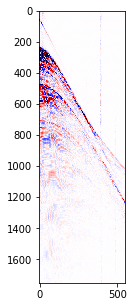

In [25]:
x = reader.load_img(0)
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
ax1.imshow(x, cmap="seismic")

### usando como tf dataset

In [26]:
reader = MultiInlineReader(
    path="../data/sgy/",
    batch_size=1
)
segy_ds = reader.make_dataset()
segy_ds

<DatasetV1Adapter shapes: <unknown>, types: tf.float32>

In [27]:
tf_iter = segy_ds.make_initializable_iterator()
tf_iter

In [28]:
tf_iter_init = tf_iter.make_initializer(segy_ds)
tf_iter_init

<tf.Operation 'make_initializer_2' type=MakeIterator>

In [29]:
x = tf_iter.get_next()
x

<tf.Tensor 'IteratorGetNext_4:0' shape=<unknown> dtype=float32>

x_shape:  (1, 1751, 550)
x_shape:  (1, 1751, 23)
x_shape:  (1, 1751, 10)
x_shape:  (1, 1751, 8)
x_shape:  (1, 1751, 10)
x_shape:  (1, 1751, 13)
x_shape:  (1, 1751, 10)
x_shape:  (1, 1751, 8)
x_shape:  (1, 1751, 6)
x_shape:  (1, 1751, 565)
x_shape:  (1, 1751, 14)
x_shape:  (1, 1751, 5)
x_shape:  (1, 1751, 4)
x_shape:  (1, 1751, 3)
x_shape:  (1, 1751, 2)
x_shape:  (1, 1751, 3)
x_shape:  (1, 1751, 2)
x_shape:  (1, 1751, 2)
x_shape:  (1, 1751, 1)
x_shape:  (1, 1751, 2)
x_shape:  (1, 1751, 2)
x_shape:  (1, 1751, 1)
x_shape:  (1, 1751, 2)
x_shape:  (1, 1751, 1)
x_shape:  (1, 1751, 1)
x_shape:  (1, 1751, 2)
x_shape:  (1, 1751, 1)


/home/luis/MyComputer/Projetos/virtual-environments/.virtualenvs/image-transformer/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


x_shape:  (1, 5001, 647)
x_shape:  (1, 5001, 351)
x_shape:  (1, 2001, 320)


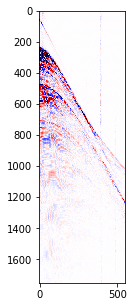

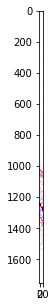

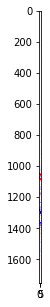

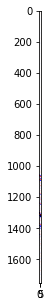

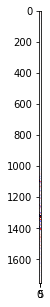

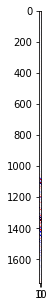

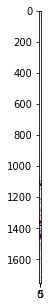

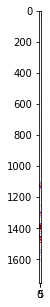

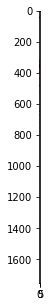

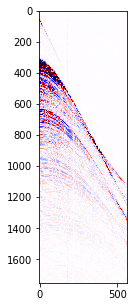

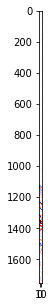

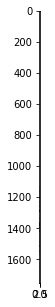

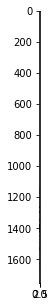

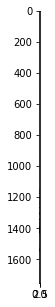

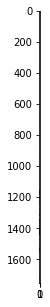

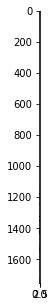

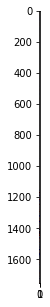

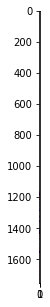

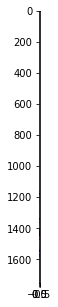

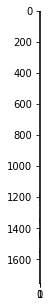

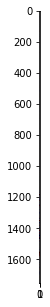

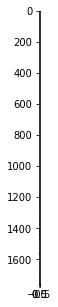

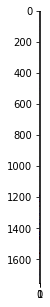

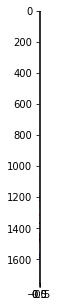

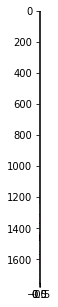

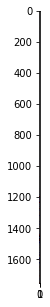

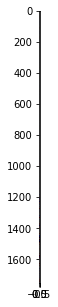

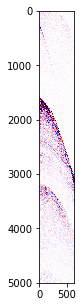

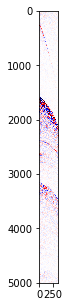

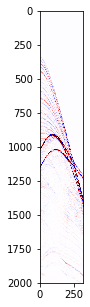

In [30]:
with tf.Session() as sess:
    # inicia o iterator o iterator
    sess.run(tf_iter_init)
    try:
        # itera sobre todas as imagens
        while True:
            outs = sess.run([x])
            print("x_shape: ", outs[0].shape)
            fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
            ax1.imshow(outs[0][0], cmap="seismic")
    except tf.errors.OutOfRangeError:
        pass

## Iterando pelo python    

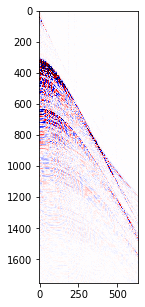

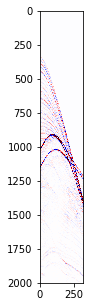

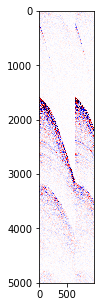

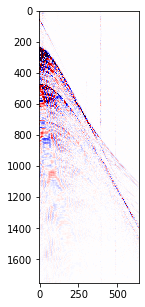

In [12]:
for x, y in reader:
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    ax1.imshow(x, cmap="seismic")